**Lattice Maker**

*By R. Vasudevan*

Here is a simple lattice maker for 2D crystals

There are only five different types. They are called Bravais Lattice types, 
and in effect are the only way that you can form repeating structures in 2D.
Therefore any 2D crystal must fall into one of these five types. 

---



![alt text](https://upload.wikimedia.org/wikipedia/commons/e/ee/2d-bravais.svg)

These are called:

*   m - Oblique
*   o - Centered Rectangle (if c==d and the angle is not 90), or Rectangle (if $\theta$= 90)
*   h - Hexagonal
*   t - Square




The goal here is to (a) Simulate the five different types, (b) Add rotations and noise, and (c) Create a simple image classifier. 

To make the problem simpler, instead of classifying the original images, we will classify the 2D fast Fourier Transform of the images.

First, we begin by importing the necessary packages.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from scipy.signal import hamming

Next, here are three functions:

(1) Create an oblique lattice
(2) Convert this lattice (which is a matrix of atomic positions) to an actual image. (3) Convolve with Gaussians to make the image of the lattice more realistic.

In [2]:
def oblique_lat(parms,nxx=20, nyy=20):
    
    """Function that creates an oblique lattice
    Inputs: - parms:  3x1 vector with parameters [a1,a2,phi]
                      where a1 is the first lattice parameter, a2 is the second
                      and phi is the angle between the two vectors in radians
            - nxx: (optional), int, number of unit cells repeated in the x direction
            - nyy: (optional), int, number of unit cells repeated in the y direction
    
    Output: atom_positions: Numpy Matrix of size (nxx*nyy,2)"""
   
     
    a1 = parms[0]
    a2 = parms[1]
    phi = parms[2]

    #Create lattice

    nx,ny = np.meshgrid(np.arange(nxx), np.arange(nyy))

    atom_pos = []
    for nxx, nyy in zip(nx.ravel(),ny.ravel()):
        x_ind = nxx * a1 + nyy * a2 * np.cos(phi)
        y_ind = nyy * a2 * np.sin(phi)

        atom_pos.append((x_ind,y_ind))

    return np.array(atom_pos)


def atom_to_img(atom_pos,img_dim = 1024):
    """Function that takes a list of atomic positions and converts them to an
    image
    Inputs: - atom_pos: output matrix of size (Nx2) with (x,y) coordinates of 
                        atoms in the lattice.
            - img_dim: (optional), int, size of image. Square images only.
            
    Output: atom_positions: Numpy Matrix of size (nxx*nyy,2)"""
    image_atoms = np.zeros((img_dim,img_dim))
    
    max_x = np.max(atom_pos[:,0])
    max_y = np.max(atom_pos[:,1])

    min_x = np.min(atom_pos[:,0])
    min_y = np.min(atom_pos[:,1])
    
    for ind in range(atom_pos.shape[0]):
        max_val = max(max_x, max_y)
        min_val = min(min_x, min_y)
        
        x1,y1 = atom_pos[ind,0], atom_pos[ind,1]
        x_img = int((x1 - min_val)/(max_val - min_val) * (img_dim-1)) #are we placing the images only at the integer coordinates?
        y_img = int((y1-min_val)/(max_val - min_val) * (img_dim-1))
          
        image_atoms[x_img, y_img]=1E6 #Place an intense point in the image at 
                                      #that atomic site
        
    return image_atoms

def convolve_atomic_img(image_atoms, sigma = 6):
  """Convolve input image with gaussian filter.
  Input: - image_atoms: 2D Numpy Array
         - sigma: int, optional, std. dev. of Gaussian
  Output: - filtered_image: 2D Numpy array, same size as input image"""
  
  return gaussian_filter(image_atoms,sigma,order = 0)

Let's simulate some different oblique lattices. Use a random generator to randomly
select lattice parameters and angles. Then, also plot the 2D fast Fourier Transform (FFT)

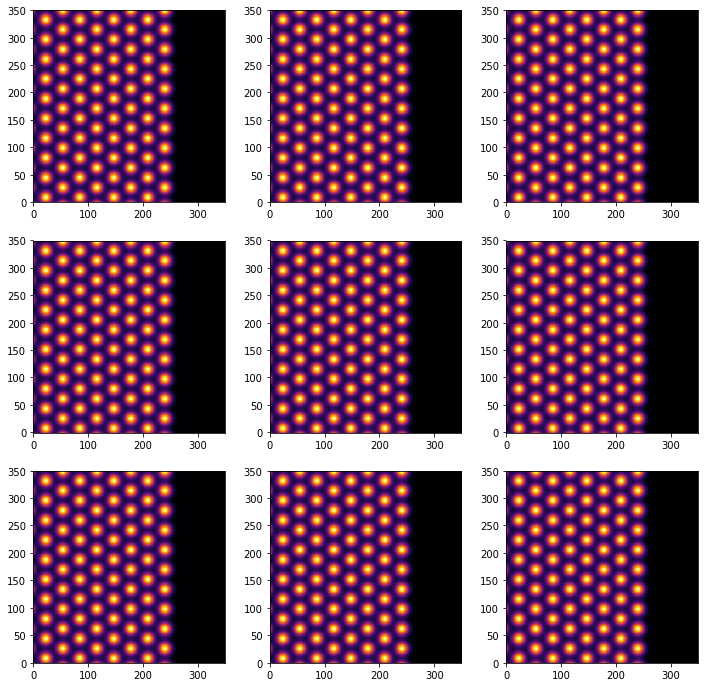

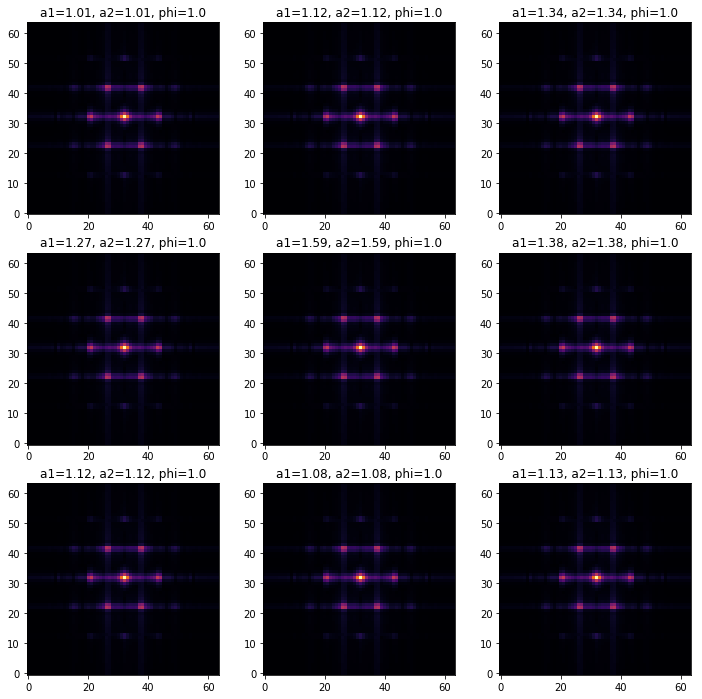

In [7]:
from scipy import ndimage
a1_list = np.random.uniform(low = 1.0, high = 1.6,size = 10)
a2_list = a1_list #np.random.uniform(low = 1.0, high = 1.6, size=10)
phi_list = np.random.uniform(low = np.pi/3, high = np.pi/3, size = 10)
img_ffts=[]
fft_win_size = 128

fig, axes = plt.subplots(nrows=3,ncols=3, figsize = (12,12))
for ind, ax in enumerate(axes.flat):
    parms_rhomb1 = [a1_list[ind], a2_list[ind], phi_list[ind]]
    latt = oblique_lat(parms_rhomb1)
    img = atom_to_img(latt)
    convolved_img = convolve_atomic_img(img, sigma = 8)
    convolved_img_cropped = convolved_img[350:700, 350:700]        
    ax.imshow(convolved_img_cropped, cmap= plt.cm.inferno)
    ax.grid(False)
    ax.invert_yaxis()
    
    #Calcualte the fft window
    n = convolved_img_cropped.shape[0]
    h = hamming(n) 
    ham2d = np.sqrt(np.outer(h,h)) 
    
    #Apply window
    img_windowed = np.copy(convolved_img_cropped)
    img_windowed *= ham2d 
    
    #Do the fft and append result
    img_fft = np.fft.fftshift(np.fft.fft2(img_windowed))
    img_fft = img_fft[convolved_img_cropped.shape[0]//2 - fft_win_size//4:convolved_img_cropped.shape[0]//2+fft_win_size//4,
                                 convolved_img_cropped.shape[0]//2 - fft_win_size//4:convolved_img_cropped.shape[0]//2+fft_win_size//4]
    
#     img_ffts = img_fft
#     img_fft = ndimage.zoom(img_fft, 5.0)
#     img_fft = 
    img_ffts.append((img_fft,parms_rhomb1))

fig2, axes2 = plt.subplots(nrows=3, ncols=3, figsize = (12,12))
for ind, ax in enumerate(axes2.flat):
    
    ax.imshow(ndimage.zoom(np.sqrt(np.abs(img_ffts[ind][0])),1), cmap = plt.cm.inferno)
    ax.grid(False)
    ax.invert_yaxis()
    ax.set_title('a1={}, a2={}, phi={}'.format(np.round(img_ffts[ind][1][0],2),
                                               np.round(img_ffts[ind][1][1],2),
                                               np.round(img_ffts[ind][1][2]),2))

**Tasks to Complete**

**1.   Create the five different types of Bravais lattice structures**. They can all be made using the same function above (*oblique_lat*). How? The only difference is in the parameters fed. There are three parameters: the first lattice parameter, a<sub>1</sub>, the second lattice parameter, a<sub>2</sub>, and the angle between them, $\phi$. These are passed as a vector, *parm* =[a<sub>1</sub>,a<sub>2</sub>,$\phi$] to *oblique_lat*.

if a<sub>1</sub> != a<sub>2</sub>, and $\phi$ is not $\pi$/2 then you have an oblique lattice

If a<sub>1</sub> == a<sub>2</sub>, and $\phi$ is not $\pi$/2 then you have a centered rectangle lattice

If a<sub>1</sub> == a<sub>2</sub> and $\phi$ is $\pi$/2 then you have a square lattice

If a<sub>1</sub> != a<sub>2</sub> and $\phi$ is $\pi$/2 then you have a rectangular lattice

If  a<sub>1</sub> == a<sub>2</sub> and $\phi$ is 2$\pi$/3 then you have a hexagonal lattice


**2.   Add rotations and distortions to the Bravais lattice structures**. 

When we image crystals, the orientations can be arbitrary. This means that we need to add a global rotation to the image. Go ahead and after you have created images from the five classes above, add rotations to this set. Finally, add distortions (random displacements) to the atomic positions.  **(How many distortions per image and what's the level of distortions?)**

**3.   Convert the functions so that you use python generators, rather than saving the data. **. 

Saving large image files that can be generated on the fly is inefficeint. Using generators, which are python constructs, is much more efficient as only a set number (e.g. 128) images are stored in memory. Convert your lattice generating functions to generators, that will then produce a set number of images when called.  



